In [1]:
%load_ext autoreload
%autoreload 2

from preprocess import *
import TemporalClusterer as tc
import numpy as np
import pandas as pd

import umap
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (7, 5)})

day_start=22
day_end=29

file_list = ['2019-08-{}'.format(x) for x in range(day_start, day_end)]

df = pd.DataFrame()
for file_name in file_list:
    df = df.append(pd.read_pickle('../../data/'+file_name+'.pcl'))
    

In [3]:
tfrom = datetime.datetime.fromisoformat('2019-08-{} 00:00:00'.format(day_start)).timestamp()
tto = datetime.datetime.fromisoformat('2019-08-{} 23:59:59'.format(day_end)).timestamp()

df = df.loc[(df['timestamp'] >= tfrom) & (df['timestamp'] < tto), :]
df['hour'] = ((df.timestamp - tfrom) / 3600).astype(np.int)
ips_in_hour = df[['ip','hour']].groupby('hour').agg([set, lambda x: len(set(x))])

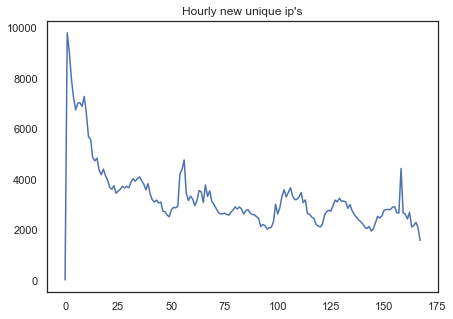

In [4]:
tmp=ips_in_hour.iloc[0,0]
lst=[]
for a in ips_in_hour.iloc[:,0]:
    lst.append((len(set.difference(a, tmp))))
    tmp=tmp.union(a)

sns.lineplot(data=np.array(lst))
plt.savefig('../../data/figures/unique_ip.png')
plt.title('Hourly new unique ip\'s');

In [23]:
df['day'] = (df.hour/24).astype(np.int)
lst = df[['ip','day']].groupby('ip').agg(lambda x:(list(set(x))))
val_cnt = 7
preclust = pd.DataFrame(data=np.stack(lst.day.apply(get_bin_series, args=[val_cnt])), index=lst.index)
preclust['ip'] = lst.index
weirdo = preclust.groupby(list(range(0,val_cnt)))['ip'].apply(list)
weirdo.head()
lnght=weirdo.apply(len)


In [25]:
# dont do this in production, do the final aggregation 
# and use groups as row selector, tho its pretty fast
for idx in range(0,len(weirdo)):
    df.loc[df['ip'].isin(weirdo.iloc[idx]),'label']=idx
    
    pass  #df.loc[weirdo.iloc[idx,0],'label'] = 
    

In [28]:
dfc = df.loc[df.label==1,:]
print(len(dfc))
c = tc.TemporalClusterer() # Set reasonable paramters, otherwise it will not run
dfc['labels'] = c.fit_transform(dfc, [])


C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
dfc[dfc.labels>-1].head()
dfc.labels.max()

120

In [38]:
c = tc.TemporalClusterer() # Set reasonable paramters, otherwise it will not run
label_ofs = 0
for x in range(0,len(weirdo)):
    dfc = df.loc[df.ip.isin(weirdo.iloc[x]),:]
    lls= pd.Series(data = c.fit_transform(dfc, []) + label_ofs, index=dfc.index)
    label_ofs += dfc.labels.max() + 1
    
    print(x)
    df['labels'] = lls

#then what to draw 
#we need some kind off ground truth

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0
1


ValueError: cannot reindex from a duplicate axis

Text(0.5, 1.0, "Hourly new unique ip's")

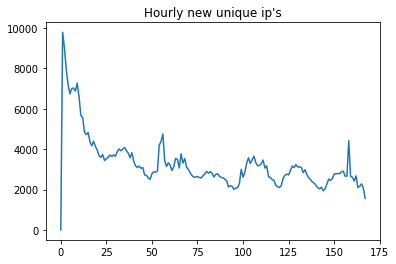

In [53]:
tmp=ips_in_hour.iloc[0,0]
lst=[]
for a in ips_in_hour.iloc[:,0]:
    lst.append((len(set.difference(a, tmp))))
    tmp=tmp.union(a)

sns.lineplot(data=np.array(lst))
plt.title('Hourly new unique ip\'s');

In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

